In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge, ARDRegression
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, MissingIndicator
from pykrige.ok import OrdinaryKriging
from pykrige.ok3d import OrdinaryKriging3D
import time

Coordinates for ADL HQ was obtained from [here](https://latitude.to/articles-by-country/es/spain/40531/paseo-de-la-castellana). Elevation for ADL HQ was obtained from [here](https://www.freemaptools.com/elevation-finder.htm).

In [2]:
# Reading in data from etl step.
df = pd.read_csv("data/intermediate/td_data.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

# Reading in station attribute file and appending ADL HQ details.
attr = pd.read_csv("data/station/attributes.csv")
attr = attr.append({'name': 'ADL HQ', 
                    'id': 0,
                    'address': 'Paseo de la Castellana, 13, 28046 Madrid, Spain',
                    'elevation': 691}, ignore_index=True)

# Reading in geojson file and appending ADL HQ details.
stations = gpd.read_file("data/station/locations.geojson")
stations = stations.append({'id': 0, 
                          'lon': -3.688163914, 
                          'lat': 40.439664908, 
                          'geometry': Point(-3.688163914, 40.439664908)}, 
                         ignore_index=True)

# Merging the two together.
stations = stations.merge(attr, on='id', how='left')

# Creating an indicator for the legend.
stations['HQ'] = np.where(stations['name'] == 'ADL HQ', 'ADL Headquarters', 'Station')

# Renaming id to station
stations.rename(columns={'id': 'station'}, inplace=True)

Next we can examine how the stations are spread across Madrid relative to the ADL head quarters.

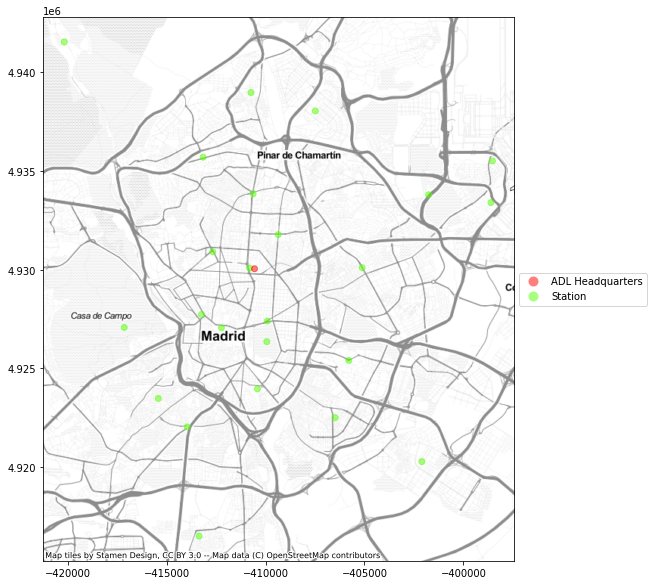

In [3]:
plt = stations.to_crs(epsg=3857).plot(figsize=(10,10), 
                                     column=stations.HQ, 
                                     label=stations.HQ, 
                                     alpha=0.5,
                                     legend=True, 
                                     legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)},
                                     cmap='prism')
ctx.add_basemap(plt, source=ctx.providers.Stamen.TonerLite)

In [4]:
df2 = df.merge(stations[['station']], on='station', how='inner')

df.groupby(['date']).mean().reset_index().isnull().sum().sort_values() / len(df.groupby(['date']).mean().reset_index())

date         0.000000
cos_time     0.000000
sin_time     0.000000
station      0.000000
sin_month    0.000000
cos_month    0.000000
NO_2         0.000114
NOx          0.000114
O_3          0.000114
PM25         0.000114
SO_2         0.000114
TCH          0.000114
TOL          0.000114
EBE          0.000114
CO           0.000114
BEN          0.000114
NMHC         0.000114
PM10         0.000152
OXY          0.206775
MXY          0.206775
PXY          0.206965
dtype: float64

Missing CO values are 35.5% for the raw data. Try aggregated by day to see if this improves it.

In [5]:
missing_percent = df2[df2['station'] != 0].isnull().sum().sort_values() / len(df2[df2['station'] != 0])

print(missing_percent)

predictors = list(missing_percent[(missing_percent <= missing_percent['CO']) & (missing_percent > 0)].index)

print(predictors)

date         0.000000
cos_time     0.000000
sin_time     0.000000
station      0.000000
sin_month    0.000000
cos_month    0.000000
NO_2         0.356178
NOx          0.356195
O_3          0.522443
PM10         0.524696
SO_2         0.548943
CO           0.582156
TCH          0.816237
NMHC         0.817001
BEN          0.828743
EBE          0.828783
TOL          0.829032
PM25         0.861273
OXY          0.966307
MXY          0.966310
PXY          0.966315
dtype: float64
['NO_2', 'NOx', 'O_3', 'PM10', 'SO_2', 'CO']


Aggregating by day only improves the percentage to 35.3%. Have a look at how individual stations are recording values.

In [6]:
df_day = df2[df2['station'] != 0].groupby([df2['date'].dt.date, 'station']).agg(np.nanmean).reset_index()

print(df_day.isnull().sum().sort_values() / len(df_day))

date         0.000000
cos_time     0.000000
sin_time     0.000000
sin_month    0.000000
cos_month    0.000000
station      0.000000
NO_2         0.352582
NOx          0.352582
O_3          0.518291
PM10         0.521739
SO_2         0.546748
CO           0.580278
TCH          0.814316
NMHC         0.815069
TOL          0.825849
BEN          0.825849
EBE          0.825849
PM25         0.859895
MXY          0.965202
OXY          0.965202
PXY          0.965281
dtype: float64


Now breaking the stations down and looking at missing CO values as well as length of time reported for (26280 reports is 3 years). Some stations report 100 % missing values for their whole time periods which will be neglected from the set. Those remaining are present for much more of the year as well as having almost complete NOx and NO2 reading which could be used to predict some of the missing CO values. However two of the remaining stations are missing O3, PM10 and SO2 for the whole time period, and in addition they have only reported for about a third of the time period, therefore these will also be dropped.

In [7]:
def get_null_perc(x, dfin, keep_length=False, grpby=['station']):
    xna = '_'.join([x, 'na'])
    df = dfin.copy()
    df[xna] = df[x].isnull()
    
    sm = df[['station', xna, 'date']].groupby(grpby).agg(
        length=(xna, 'size'),
        na_sum=(xna, 'sum'), 
        mindate=('date', 'min'), 
        maxdate=('date', 'max')
    )
    
    sm['_'.join([xna.lower(), 'perc'])] = sm['na_sum'] / sm['length'] * 100
    sm = sm.filter(regex='perc|date|length').reset_index()
    return(sm)

dfin = df2

sm = get_null_perc(predictors[0], dfin)
for x in predictors[1:]:
    sm = sm.merge(get_null_perc(x, dfin), on=['station', 'length', 'mindate', 'maxdate'], how='inner')

# Looking at all stations
# print(sm)

# Filtering out those with 100% missing CO values
# print(sm[sm['co_na_perc'] < 100])

# Filtering out the remaining stations with low reporting rate
print(sm[(sm['co_na_perc'] < 30)])
chosen_station_id = sm.loc[(sm['co_na_perc'] < 30), 'station'].values.tolist() + [0]

       station  length             mindate    maxdate  no_2_na_perc  \
1   28079004.0   26304 2016-01-01 01:00:00 2019-01-01      0.710918   
2   28079008.0   26304 2016-01-01 01:00:00 2019-01-01      1.132908   
4   28079016.0   26304 2016-01-01 01:00:00 2019-01-01      0.190085   
6   28079018.0   26304 2016-01-01 01:00:00 2019-01-01      0.361162   
7   28079024.0   26304 2016-01-01 01:00:00 2019-01-01      2.387470   
9   28079036.0   26304 2016-01-01 01:00:00 2019-01-01      0.159672   
11  28079039.0   26304 2016-01-01 01:00:00 2019-01-01      0.292731   

    nox_na_perc  o_3_na_perc  pm10_na_perc  so_2_na_perc  co_na_perc  
1      0.710918    33.842762     34.188717      0.729927    0.699513  
2      1.129106     1.155718      9.838808      0.878193    0.805961  
4      0.193887     0.269921     33.645073     33.466393    0.064629  
6      0.361162     0.364964      0.600669      0.410584    0.330748  
7      2.410280     2.604167      2.223996      2.269617    2.265815  
9    

Now checking to see if missing values are regular or not.

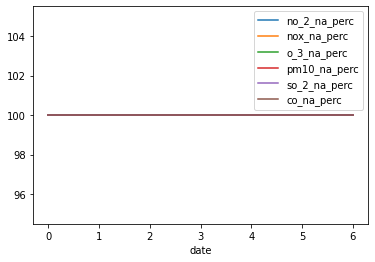

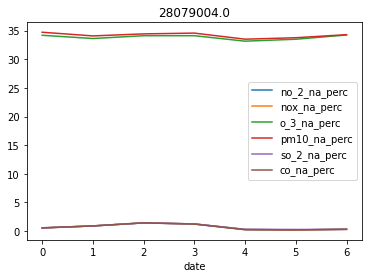

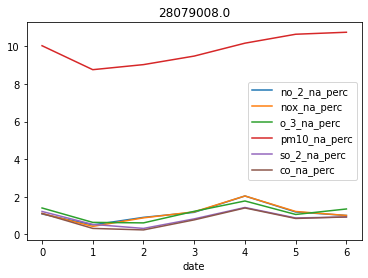

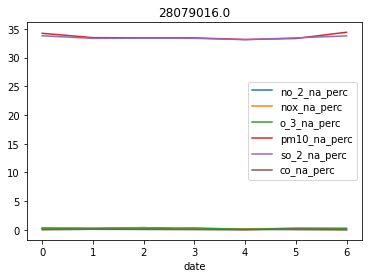

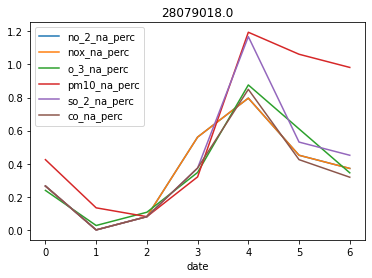

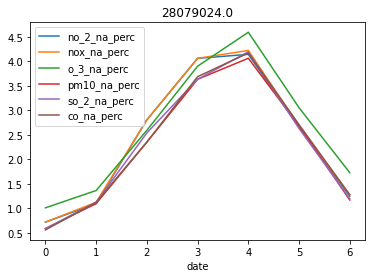

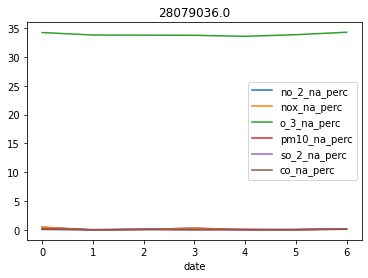

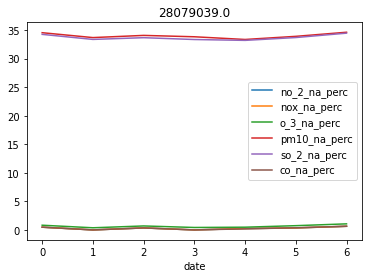

In [8]:
dft = df2.copy()

dft['date'] = dft.date.dt.dayofweek

dfin = dft

sm = get_null_perc(predictors[0], dfin, grpby=['station', 'date'])
for x in predictors[1:]:
    sm = sm.merge(get_null_perc(x, dfin, grpby=['station', 'date']), on=['station', 'length', 'mindate', 'maxdate', 'date'], how='inner')

sm = sm.drop(columns=['mindate', 'maxdate','length'])
sm = sm[sm['station'].isin(chosen_station_id)]

for stn in sm.station.unique():
    sm[(sm['station'] == stn)].drop(columns=['station']).plot(x='date', title=stn)

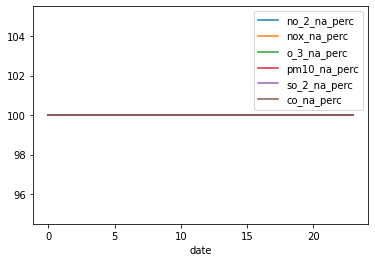

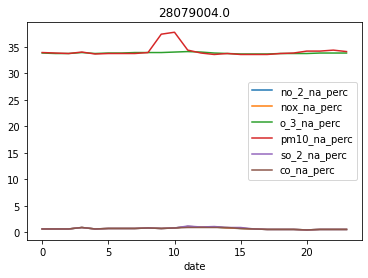

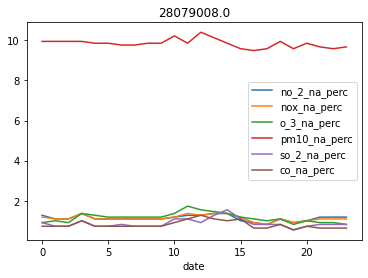

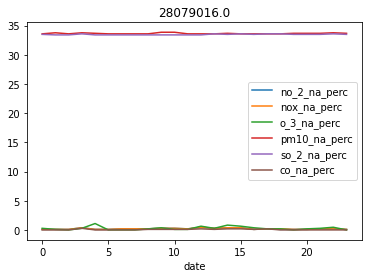

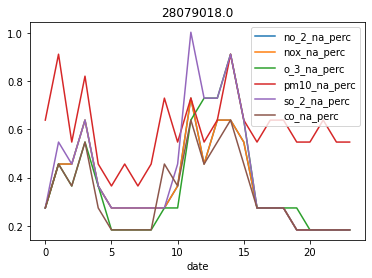

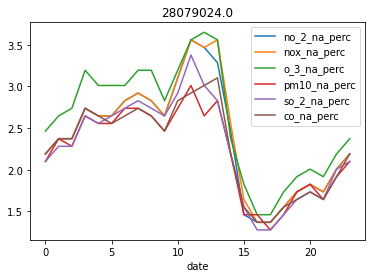

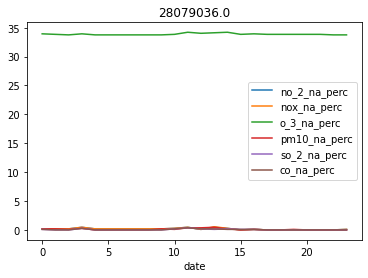

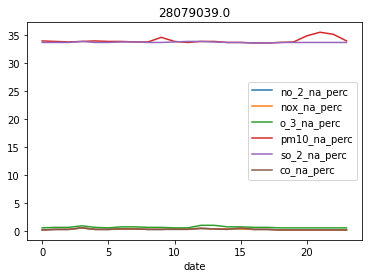

In [9]:
dft = df2.copy()

dft['date'] = dft.date.dt.hour

dfin = dft

sm = get_null_perc(predictors[0], dfin, grpby=['station', 'date'])
for x in predictors[1:]:
    sm = sm.merge(get_null_perc(x, dfin, grpby=['station', 'date']), on=['station', 'length', 'mindate', 'maxdate', 'date'], how='inner')

sm = sm.drop(columns=['mindate', 'maxdate','length'])
sm = sm[sm['station'].isin(chosen_station_id)]

for stn in sm.station.unique():
    sm[(sm['station'] == stn)].drop(columns=['station']).plot(x='date', title=stn)

These station selections appear to be well spread out about the area required for prediction.

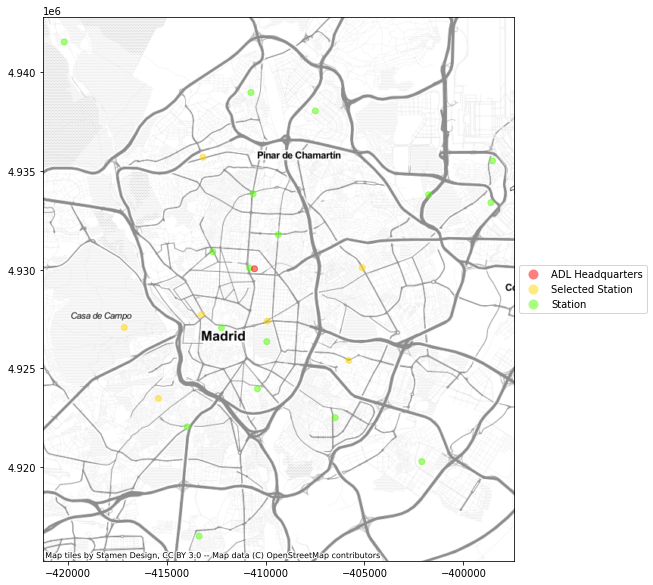

In [10]:
stations.loc[stations['station'].isin(chosen_station_id) & (stations['station'] != 0), 'HQ'] = 'Selected Station'

plt = stations.to_crs(epsg=3857).plot(figsize=(10,10), 
                                     column=stations.HQ, 
                                     label=stations.HQ, 
                                     alpha=0.5,
                                     legend=True, 
                                     legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)},
                                     cmap='prism')
ctx.add_basemap(plt, source=ctx.providers.Stamen.TonerLite)

In [11]:
chosen_stations = stations[stations['station'].isin(chosen_station_id)]

keep = ['station', 'date', 'lon', 'lat', 'elevation', 'sin_time', 'cos_time', 'sin_month', 'cos_month']
df3 = df.merge(chosen_stations[['station', 'lon', 'lat', 'elevation']], on='station', how='inner')[keep + predictors]

df3[predictors].dropna().corr()

,NO_2,NOx,O_3,PM10,SO_2,CO
NO_2,1.000000,0.879330,-0.626664,0.523563,0.438548,0.732471
NOx,0.879330,1.000000,-0.550960,0.530796,0.530696,0.860131
O_3,-0.626664,-0.550960,1.000000,-0.210015,-0.336783,-0.460393
PM10,0.523563,0.530796,-0.210015,1.000000,0.233892,0.446705
SO_2,0.438548,0.530696,-0.336783,0.233892,1.000000,0.567604
CO,0.732471,0.860131,-0.460393,0.446705,0.567604,1.000000


Looking at consecutive missing values for both NOx and NO_2, the maximum is 65 hours. Therefore the rolling mean of all the same time in the last 72 hours will be used to predict missing values.

98


<AxesSubplot:ylabel='Frequency'>

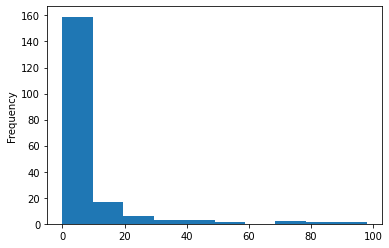

In [12]:
dft = df3.loc[df3['station'] != 0, ['station', 'date', 'NOx', 'NO_2']]

dft = dft[(dft['NO_2'].isna())]

dft['next_date'] = dft.sort_values(['date'], ascending=False).groupby(['station']).shift(1)['date']

dft['del'] = dft['next_date'] - dft['date']

dft.loc[dft['del'] != pd.Timedelta(1, unit='h'), 'consec'] = 1

res = dft['consec'].isnull().astype(int).groupby(dft['consec'].notnull().astype(int).cumsum()).sum()

print(max(res))
res.plot.hist()

KNN imputation will be used to fill missing values, 

In [ ]:
dft = df3.copy()

X = dft[dft['station'] != 0].to_numpy()

indicator = MissingIndicator()
imputer = KNNImputer(n_neighbors=2, weights="uniform")
#imputer = IterativeImputer(max_iter=10, random_state=0)

missing = np.concatenate((X[:, :2], indicator.fit_transform(X[:, 2:])), axis=1)
X_p = np.concatenate((X[:, :2], imputer.fit_transform(X[:, 2:])), axis=1)

In [ ]:
df4 = pd.DataFrame().from_records(X_p)
df4.columns = df3.columns.tolist()

df4 = df4.append(dft[dft['station'] == 0], ignore_index=True)
#print(df4.isnull().sum().sort_values() / len(df4))

#df4['CO14'] = df4.sort_values(by=['date'], axis=0).groupby('station').shift(-14 * 24)['CO']
#df4['pred_date'] = df4['date'] + pd.Timedelta(days= 14)

In [ ]:
df5 = df4.copy()

df5.loc[df5['station'] == 0, predictors] = np.NaN

print(df5[df5['station'] == 0])

adl_loc = stations[stations['name'] == 'ADL HQ'][['lon', 'lat', 'elevation']]
adl_lon = adl_loc['lon']
adl_lat = adl_loc['lat']
adl_elev = adl_loc['elevation']

start = time.time()

for p in predictors[0:1]:
    for d in df4.date.unique()[0:1000]:
        OK = OrdinaryKriging(
            df4.loc[df4.date == d, 'lon'].values,
            df4.loc[df4.date == d, 'lat'].values,
            df4.loc[df4.date == d, p].values,
            coordinates_type='geographic'
        )
        z, ss = OK.execute('points', adl_lon, adl_lat)

        df5.loc[(df5.date == d) & (df5.station == 0), p] = z
        #print(z)
        #print(ss)
        
print(time.time() - start)

In [ ]:
df5[df5.station == 0]